# MACD, MACD Derivative, and RSI Feature Generation

This notebook demonstrates how to use the existing codebase to generate MACD histogram, MACD derivative, and RSI features for technical analysis.

## Features Generated:
- **MACD Histogram**: Difference between MACD line and signal line
- **MACD Derivative EMA**: 3-day exponential moving average of MACD histogram changes
- **RSI**: Relative Strength Index for multiple periods (14, 21, 30)


In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Add project src to path
project_root = os.path.abspath('.')
if os.path.exists(os.path.join(project_root, 'src')):
    sys.path.insert(0, os.path.join(project_root, 'src'))
else:
    # Try parent directory
    parent_dir = os.path.dirname(project_root)
    if os.path.exists(os.path.join(parent_dir, 'src')):
        sys.path.insert(0, os.path.join(parent_dir, 'src'))

# Import existing functions
from features.trend import add_macd_features, add_rsi_features
from data.loader import load_stock_universe, load_etf_universe

print("✅ Successfully imported existing codebase functions")
print(f"📁 Working directory: {os.getcwd()}")

/mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/anaconda3/envs/svd_forecasting/lib/python3.10/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


✅ Successfully imported existing codebase functions
📁 Working directory: /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/notebooks


## Load Sample Data

We'll load a small sample of stock data to demonstrate the feature generation process.

In [8]:
# Load sample stock universe data (limited to 10 symbols for demo)
print("📊 Loading sample stock data...")
try:
    # Try to load from cache first (faster)
    data_dict = load_stock_universe(max_symbols=10, update=False)
    if data_dict is None:
        print("⚠️ No cached data found. You may need to run the data loading pipeline first.")
        print("💡 Hint: Make sure RAPIDAPI_KEY is set in your environment if fetching fresh data.")
        # Create sample data for demonstration
        print("🔧 Creating sample data for demonstration...")
        dates = pd.date_range(start='2023-01-01', end='2024-01-01', freq='D')
        np.random.seed(42)
        sample_prices = 100 + np.cumsum(np.random.randn(len(dates)) * 0.5)
        
        data_dict = {
            'AdjClose': pd.DataFrame({
                'AAPL': sample_prices + np.random.randn(len(dates)) * 2,
                'MSFT': sample_prices * 1.1 + np.random.randn(len(dates)) * 3,
                'GOOGL': sample_prices * 0.9 + np.random.randn(len(dates)) * 2.5
            }, index=dates)
        }
        print("✅ Sample data created with 3 symbols")
    else:
        print(f"✅ Loaded stock data with {len(data_dict)} metrics")
        for metric, df in data_dict.items():
            print(f"   {metric}: {len(df.columns)} symbols, {len(df)} days")

except Exception as e:
    print(f"⚠️ Error loading stock data: {e}")
    # Fallback to sample data
    print("🔧 Creating fallback sample data...")
    dates = pd.date_range(start='2023-01-01', end='2024-01-01', freq='D')
    np.random.seed(42)
    sample_prices = 100 + np.cumsum(np.random.randn(len(dates)) * 0.5)
    
    data_dict = {
        'AdjClose': pd.DataFrame({
            'AAPL': sample_prices + np.random.randn(len(dates)) * 2,
            'MSFT': sample_prices * 1.1 + np.random.randn(len(dates)) * 3,
            'GOOGL': sample_prices * 0.9 + np.random.randn(len(dates)) * 2.5
        }, index=dates)
    }
    print("✅ Fallback sample data created")

📊 Loading sample stock data...
💾 stocks: loading cache /mnt/a61cc0e8-1b32-4574-a771-4ad77e8faab6/conda/technical_dashboard/cache/stock_data_universe.parquet
✅ Loaded stock data with 6 metrics
   AdjClose: 2953 symbols, 1255 days
   Close: 2953 symbols, 1255 days
   High: 2953 symbols, 1255 days
   Low: 2953 symbols, 1255 days
   Open: 2953 symbols, 1255 days
   Volume: 2953 symbols, 1255 days


## Prepare Data for Feature Generation

The feature generation functions expect a DataFrame with price columns. We'll prepare the data in the expected format.

In [3]:
# Get the adjusted close prices
adj_close_df = data_dict['AdjClose']
print(f"📈 Adjusted close data shape: {adj_close_df.shape}")
print(f"📅 Date range: {adj_close_df.index.min()} to {adj_close_df.index.max()}")
print(f"🏢 Symbols: {list(adj_close_df.columns)}")

# Display first few rows
print("\n📊 Sample data:")
adj_close_df.head()

📈 Adjusted close data shape: (1255, 10)
📅 Date range: 2020-09-03 00:00:00 to 2025-09-03 00:00:00
🏢 Symbols: ['A', 'AA', 'AACB', 'AACI', 'AACT', 'AAL', 'AAMI', 'AAOI', 'AAON', 'AAP']

📊 Sample data:


symbol,A,AA,AACB,AACI,AACT,AAL,AAMI,AAOI,AAON,AAP
date,,,,,,,,,,
2020-09-03,96.33,13.63,NaN,NaN,NaN,13.36,13.54,10.95,37.04,138.94
2020-09-04,93.62,13.79,NaN,NaN,NaN,13.61,13.41,10.52,36.67,137.66
2020-09-08,91.98,13.63,NaN,NaN,NaN,13.63,12.76,9.94,36.06,135.85
2020-09-09,94.68,13.50,NaN,NaN,NaN,13.05,12.98,10.24,36.16,138.20
2020-09-10,95.30,13.20,NaN,NaN,NaN,13.01,12.81,9.86,36.45,137.49


## Generate MACD Features

We'll generate MACD histogram and MACD derivative features for each symbol using the existing `add_macd_features` function.

In [4]:
# Process each symbol individually to generate MACD features
macd_results = {}

for symbol in adj_close_df.columns:
    print(f"\n🔧 Generating MACD features for {symbol}...")
    
    # Create a DataFrame with the symbol's price data
    symbol_df = pd.DataFrame({
        'adjclose': adj_close_df[symbol]
    })
    
    # Remove NaN values
    symbol_df = symbol_df.dropna()
    
    # Generate MACD features using the existing function
    try:
        symbol_df_with_macd = add_macd_features(
            symbol_df, 
            src_col='adjclose',
            fast=12, 
            slow=26, 
            signal=9,
            derivative_ema_span=3
        )
        
        # Store results
        macd_results[symbol] = symbol_df_with_macd
        
        # Show what features were generated
        macd_cols = [col for col in symbol_df_with_macd.columns if 'macd' in col.lower()]
        print(f"   ✅ Generated features: {macd_cols}")
        
    except Exception as e:
        print(f"   ❌ Error generating MACD for {symbol}: {e}")

print(f"\n🎯 MACD features generated for {len(macd_results)} symbols")


🔧 Generating MACD features for A...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AA...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AACB...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AACI...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AACT...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AAL...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AAMI...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AAOI...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AAON...
   ✅ Generated features: ['macd_histogram', 'macd_hist_deriv_ema3']

🔧 Generating MACD features for AA

## Generate RSI Features

Now we'll add RSI features for multiple periods using the existing `add_rsi_features` function.

In [5]:
# Add RSI features to each symbol's data
combined_results = {}

for symbol in adj_close_df.columns:
    if symbol in macd_results:
        print(f"\n🔧 Adding RSI features for {symbol}...")
        
        # Get the DataFrame that already has MACD features
        symbol_df = macd_results[symbol].copy()
        
        try:
            # Add RSI features using the existing function
            symbol_df_with_rsi = add_rsi_features(
                symbol_df,
                src_col='adjclose',
                periods=(14, 21, 30)
            )
            
            # Store final results
            combined_results[symbol] = symbol_df_with_rsi
            
            # Show what RSI features were generated
            rsi_cols = [col for col in symbol_df_with_rsi.columns if 'rsi' in col.lower()]
            print(f"   ✅ Generated RSI features: {rsi_cols}")
            
        except Exception as e:
            print(f"   ❌ Error generating RSI for {symbol}: {e}")
            combined_results[symbol] = symbol_df  # Keep MACD-only version

print(f"\n🎯 Complete feature set generated for {len(combined_results)} symbols")

# Show summary of all generated features
if combined_results:
    sample_symbol = list(combined_results.keys())[0]
    all_features = list(combined_results[sample_symbol].columns)
    print(f"\n📋 All features in dataset: {all_features}")


🔧 Adding RSI features for A...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AA...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AACB...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AACI...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AACT...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AAL...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AAMI...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AAOI...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AAON...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🔧 Adding RSI features for AAP...
   ✅ Generated RSI features: ['rsi_14', 'rsi_21', 'rsi_30']

🎯 Complete feature set generated for 10 symbols

📋 All f

## Visualize Generated Features

Let's create visualizations to examine the generated MACD and RSI features.

📊 Visualizing features for A


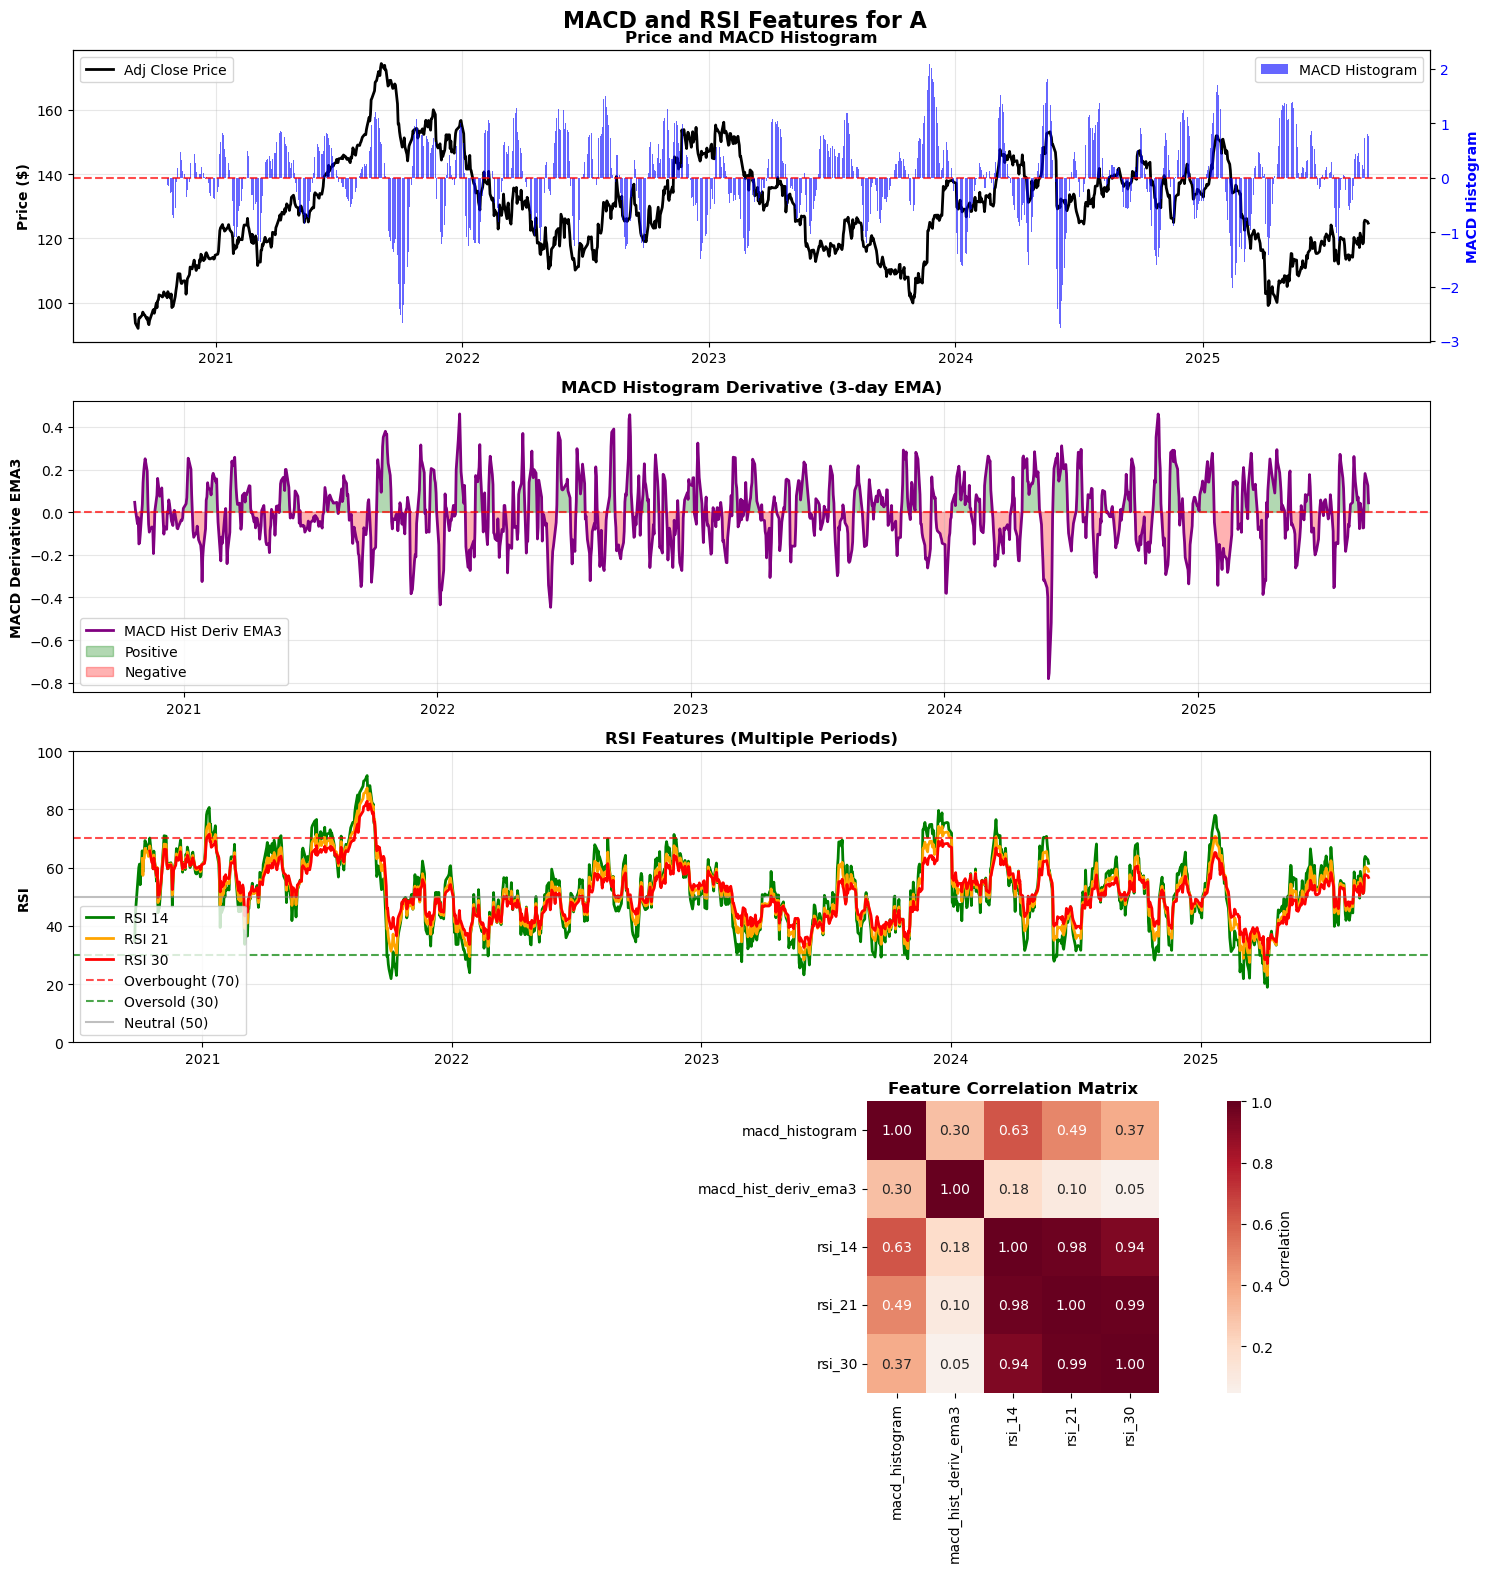

In [6]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Select first symbol for detailed visualization
if combined_results:
    symbol = list(combined_results.keys())[0]
    df = combined_results[symbol]
    
    print(f"📊 Visualizing features for {symbol}")
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 16))
    fig.suptitle(f'MACD and RSI Features for {symbol}', fontsize=16, fontweight='bold')
    
    # Plot 1: Price and MACD Histogram
    ax1 = axes[0]
    ax1_twin = ax1.twinx()
    
    # Price on left axis
    ax1.plot(df.index, df['adjclose'], label='Adj Close Price', color='black', linewidth=2)
    ax1.set_ylabel('Price ($)', fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)
    
    # MACD Histogram on right axis
    if 'macd_histogram' in df.columns:
        ax1_twin.bar(df.index, df['macd_histogram'], alpha=0.6, color='blue', width=1, label='MACD Histogram')
        ax1_twin.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax1_twin.set_ylabel('MACD Histogram', color='blue', fontweight='bold')
        ax1_twin.tick_params(axis='y', labelcolor='blue')
    
    ax1.set_title('Price and MACD Histogram', fontweight='bold')
    ax1.legend(loc='upper left')
    if 'macd_histogram' in df.columns:
        ax1_twin.legend(loc='upper right')
    
    # Plot 2: MACD Histogram Derivative EMA
    ax2 = axes[1]
    if 'macd_hist_deriv_ema3' in df.columns:
        ax2.plot(df.index, df['macd_hist_deriv_ema3'], color='purple', linewidth=2, label='MACD Hist Deriv EMA3')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax2.fill_between(df.index, df['macd_hist_deriv_ema3'], 0, 
                         where=(df['macd_hist_deriv_ema3'] > 0), alpha=0.3, color='green', label='Positive')
        ax2.fill_between(df.index, df['macd_hist_deriv_ema3'], 0, 
                         where=(df['macd_hist_deriv_ema3'] < 0), alpha=0.3, color='red', label='Negative')
        ax2.set_ylabel('MACD Derivative EMA3', fontweight='bold')
        ax2.legend()
    ax2.set_title('MACD Histogram Derivative (3-day EMA)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: RSI Features
    ax3 = axes[2]
    rsi_colors = ['green', 'orange', 'red']
    rsi_periods = [14, 21, 30]
    
    for i, period in enumerate(rsi_periods):
        rsi_col = f'rsi_{period}'
        if rsi_col in df.columns:
            ax3.plot(df.index, df[rsi_col], color=rsi_colors[i], linewidth=2, label=f'RSI {period}')
    
    # Add RSI reference lines
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
    ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
    ax3.axhline(y=50, color='gray', linestyle='-', alpha=0.5, label='Neutral (50)')
    
    ax3.set_ylabel('RSI', fontweight='bold')
    ax3.set_ylim(0, 100)
    ax3.set_title('RSI Features (Multiple Periods)', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Feature Correlation Heatmap
    ax4 = axes[3]
    
    # Select technical features for correlation
    tech_features = [col for col in df.columns if any(x in col.lower() for x in ['macd', 'rsi'])]
    if tech_features:
        corr_data = df[tech_features].corr()
        
        # Create heatmap
        sns.heatmap(corr_data, annot=True, cmap='RdBu_r', center=0, 
                   square=True, fmt='.2f', cbar_kws={'label': 'Correlation'}, ax=ax4)
        ax4.set_title('Feature Correlation Matrix', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ No data available for visualization")

## Feature Statistics and Analysis

Let's examine the statistical properties of our generated features.

In [7]:
if combined_results:
    # Create a summary of all features across all symbols
    print("📊 FEATURE STATISTICS SUMMARY")
    print("=" * 50)
    
    for symbol in combined_results.keys():
        df = combined_results[symbol]
        print(f"\n🏢 {symbol}:")
        print(f"   📅 Data period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
        print(f"   📈 Total observations: {len(df)}")
        
        # MACD Statistics
        if 'macd_histogram' in df.columns:
            macd_hist = df['macd_histogram'].dropna()
            print(f"\n   📊 MACD Histogram:")
            print(f"      Mean: {macd_hist.mean():.4f}")
            print(f"      Std:  {macd_hist.std():.4f}")
            print(f"      Min:  {macd_hist.min():.4f}")
            print(f"      Max:  {macd_hist.max():.4f}")
            print(f"      % Positive: {(macd_hist > 0).mean()*100:.1f}%")
        
        if 'macd_hist_deriv_ema3' in df.columns:
            macd_deriv = df['macd_hist_deriv_ema3'].dropna()
            print(f"\n   📈 MACD Histogram Derivative EMA3:")
            print(f"      Mean: {macd_deriv.mean():.6f}")
            print(f"      Std:  {macd_deriv.std():.6f}")
            print(f"      % Positive: {(macd_deriv > 0).mean()*100:.1f}%")
        
        # RSI Statistics
        rsi_cols = [col for col in df.columns if 'rsi_' in col]
        if rsi_cols:
            print(f"\n   🎯 RSI Features:")
            for rsi_col in rsi_cols:
                rsi_data = df[rsi_col].dropna()
                period = rsi_col.split('_')[1]
                print(f"      RSI-{period}: Mean={rsi_data.mean():.1f}, "
                      f"Overbought(>70)={((rsi_data > 70).mean()*100):.1f}%, "
                      f"Oversold(<30)={((rsi_data < 30).mean()*100):.1f}%")
        
        print("-" * 40)
    
    # Create a combined features DataFrame for cross-symbol analysis
    print("\n🔍 CROSS-SYMBOL FEATURE ANALYSIS")
    print("=" * 40)
    
    # Combine all MACD histogram data
    all_macd_hist = []
    all_rsi_14 = []
    
    for symbol in combined_results.keys():
        df = combined_results[symbol]
        if 'macd_histogram' in df.columns:
            all_macd_hist.extend(df['macd_histogram'].dropna().tolist())
        if 'rsi_14' in df.columns:
            all_rsi_14.extend(df['rsi_14'].dropna().tolist())
    
    if all_macd_hist:
        all_macd_hist = np.array(all_macd_hist)
        print(f"📊 Combined MACD Histogram ({len(all_macd_hist)} observations):")
        print(f"   Mean: {all_macd_hist.mean():.4f}")
        print(f"   Median: {np.median(all_macd_hist):.4f}")
        print(f"   Std: {all_macd_hist.std():.4f}")
        print(f"   25th percentile: {np.percentile(all_macd_hist, 25):.4f}")
        print(f"   75th percentile: {np.percentile(all_macd_hist, 75):.4f}")
    
    if all_rsi_14:
        all_rsi_14 = np.array(all_rsi_14)
        print(f"\n🎯 Combined RSI-14 ({len(all_rsi_14)} observations):")
        print(f"   Mean: {all_rsi_14.mean():.1f}")
        print(f"   Median: {np.median(all_rsi_14):.1f}")
        print(f"   % Overbought (>70): {(all_rsi_14 > 70).mean()*100:.1f}%")
        print(f"   % Oversold (<30): {(all_rsi_14 < 30).mean()*100:.1f}%")
        print(f"   % Neutral (30-70): {((all_rsi_14 >= 30) & (all_rsi_14 <= 70)).mean()*100:.1f}%")

else:
    print("⚠️ No results available for analysis")

📊 FEATURE STATISTICS SUMMARY

🏢 A:
   📅 Data period: 2020-09-03 to 2025-09-03
   📈 Total observations: 1255

   📊 MACD Histogram:
      Mean: -0.0040
      Std:  0.7736
      Min:  -2.7699
      Max:  2.0993
      % Positive: 54.3%

   📈 MACD Histogram Derivative EMA3:
      Mean: 0.000772
      Std:  0.155590
      % Positive: 49.3%

   🎯 RSI Features:
      RSI-14: Mean=51.5, Overbought(>70)=8.1%, Oversold(<30)=3.9%
      RSI-21: Mean=51.5, Overbought(>70)=4.3%, Oversold(<30)=0.9%
      RSI-30: Mean=51.3, Overbought(>70)=1.9%, Oversold(<30)=0.2%
----------------------------------------

🏢 AA:
   📅 Data period: 2020-09-03 to 2025-09-03
   📈 Total observations: 1255

   📊 MACD Histogram:
      Mean: 0.0024
      Std:  0.4970
      Min:  -2.7321
      Max:  1.3227
      % Positive: 54.3%

   📈 MACD Histogram Derivative EMA3:
      Mean: -0.000064
      Std:  0.104270
      % Positive: 50.5%

   🎯 RSI Features:
      RSI-14: Mean=51.1, Overbought(>70)=5.6%, Oversold(<30)=3.2%
      RSI-2

## Export Features to DataFrame

Finally, let's create a consolidated DataFrame with all generated features that can be used for further analysis or modeling.

In [ ]:
if combined_results:
    print("💾 Creating consolidated features DataFrame...")
    
    # Create a list to store all symbol data
    all_symbol_data = []
    
    for symbol, df in combined_results.items():
        # Add symbol column
        symbol_df = df.copy()
        symbol_df['symbol'] = symbol
        symbol_df = symbol_df.reset_index()  # Make date a column
        all_symbol_data.append(symbol_df)
    
    # Combine all symbol data
    consolidated_df = pd.concat(all_symbol_data, ignore_index=True)
    
    # Sort by symbol and date
    consolidated_df = consolidated_df.sort_values(['symbol', 'date'])
    
    print(f"✅ Consolidated DataFrame created:")
    print(f"   📊 Shape: {consolidated_df.shape}")
    print(f"   🏢 Symbols: {consolidated_df['symbol'].nunique()}")
    print(f"   📅 Date range: {consolidated_df['date'].min()} to {consolidated_df['date'].max()}")
    print(f"   📋 Features: {list(consolidated_df.columns)}")
    
    # Display sample of the consolidated data
    print("\n📋 Sample of consolidated features:")
    display_cols = ['date', 'symbol', 'adjclose'] + [col for col in consolidated_df.columns 
                                                     if any(x in col.lower() for x in ['macd', 'rsi'])]
    print(consolidated_df[display_cols].head(10))
    
    # Option to save to CSV
    save_to_csv = input("\n💾 Save consolidated features to CSV? (y/n): ").lower().strip() == 'y'
    if save_to_csv:
        output_filename = f"macd_rsi_features_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        consolidated_df.to_csv(output_filename, index=False)
        print(f"✅ Features saved to: {output_filename}")
    
else:
    print("⚠️ No results available for export")

## Summary

This notebook demonstrated how to use the existing codebase to generate:

1. **MACD Histogram**: The difference between MACD line and signal line, useful for identifying momentum changes
2. **MACD Derivative EMA**: A 3-day exponential moving average of MACD histogram changes, providing a smoothed momentum indicator
3. **RSI Features**: Relative Strength Index for periods 14, 21, and 30, indicating overbought/oversold conditions

### Key Functions Used:
- `add_macd_features()`: From `src/features/trend.py`
- `add_rsi_features()`: From `src/features/trend.py` 
- `load_stock_universe()`: From `src/data/loader.py`

### Generated Features:
- `macd_histogram`: MACD histogram values
- `macd_hist_deriv_ema3`: 3-day EMA of MACD histogram derivative
- `rsi_14`, `rsi_21`, `rsi_30`: RSI values for different periods

These features can be used directly in machine learning models or further technical analysis workflows.